In [77]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import FeatureUnion, make_union

from sklearn.model_selection import train_test_split, RandomizedSearchCV

import dill

In [78]:
df = pd.read_csv('train_airplane.csv')

Тут дописан класс для суммирования столбцов. Учитывая что мы рассматриваем градиентный бустинг, а не линейную модель, нам не нужно переделывать возраст в более мелкие категории так как это только уменьшит точность, нам не важно, что там не линейная зависимость.

In [79]:

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


class FeatureSum(BaseEstimator, TransformerMixin):
    '''
    Transform class for sum of several columns

    column - list of columns to sum

    Return: DF with one column - sum of given columns
    '''
    counter = 0
    
    def __init__(self, column):
        self.column = column
        

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        FeatureSum.counter += 1
        Xt = X[self.column].copy()
        Xt[f'sum{FeatureSum.counter}'] = Xt.sum(axis=1, skipna=True)
        return Xt[[f'sum{FeatureSum.counter}']]

In [80]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,103904,NaN,NaN,NaN,51951.5,29994.6,0,25975.8,51951.5,77927.2,103903
id,103904,NaN,NaN,NaN,64924.2,37463.8,1,32533.8,64856.5,97368.2,129880
Gender,103904,2,Female,52727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Type,103904,2,Loyal Customer,84923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,103904,NaN,NaN,NaN,39.3797,15.115,7,27,40,51,85
Type of Travel,103904,2,Business travel,71655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,103904,3,Business,49665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flight Distance,103904,NaN,NaN,NaN,1189.45,997.147,31,414,843,1743,4983
Inflight wifi service,103904,NaN,NaN,NaN,2.72968,1.32783,0,2,3,4,5
Departure/Arrival time convenient,103904,NaN,NaN,NaN,3.0603,1.52508,0,2,3,4,5


У нас есть один признак Arrival Delay in Minutes в котором не хватает примеров. Так же у нас есть 4 категориальных признака, обозначеные строковыми переменными, для них мы в пайплайне воспользуемся OrdinalEncoder. Есть много категориальных признаков без пропусков (0-1) для них добавим сумму.

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

создадим списки колонок для будущего пайплайна:
- categorical_columns - для OrdinalEncoding
- categorical_columns2 - категории 0-5 
- numerical_columns - вещественные признаки, Age переделывать не будем так как будем пользоваться нелинейной моделью.

In [82]:
categorical_columns = ['Type of Travel', 'Gender','Class', 'Customer Type']
categorical_columns2 = [ 'Inflight wifi service',
    'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service',
    'Cleanliness']

numerical_columns = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']
features = categorical_columns + numerical_columns + categorical_columns2

пеерделаем нашу целевую переменную в 1 - удволетворены и 0 - нет.

In [83]:
df.satisfaction.replace({'satisfied': 1, 'neutral or dissatisfied':  0}, inplace=True)


Посмотрим на графики

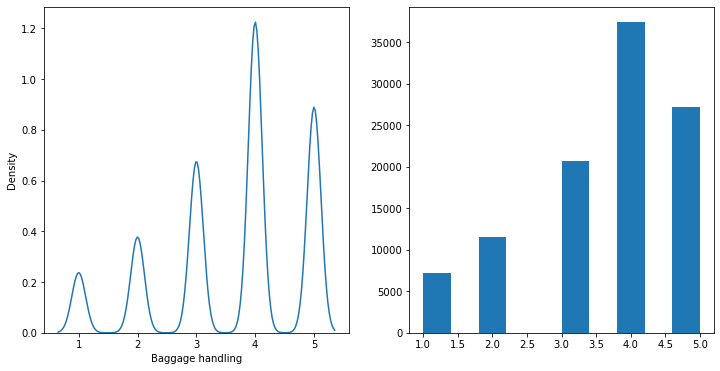

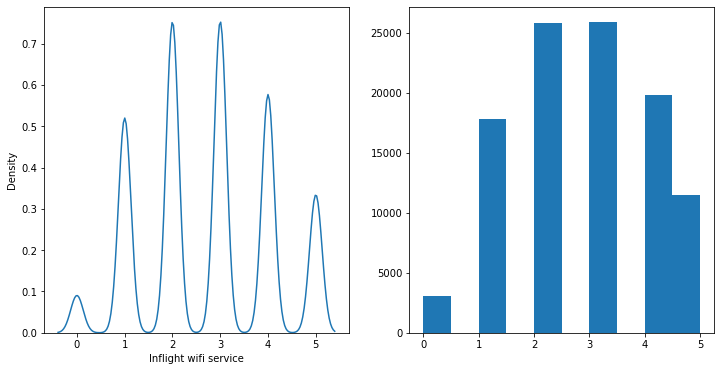

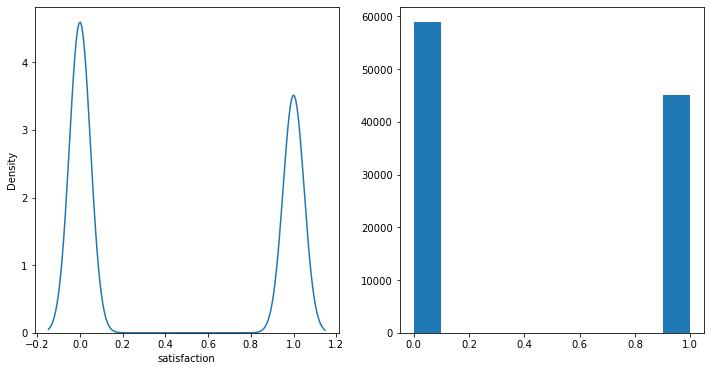

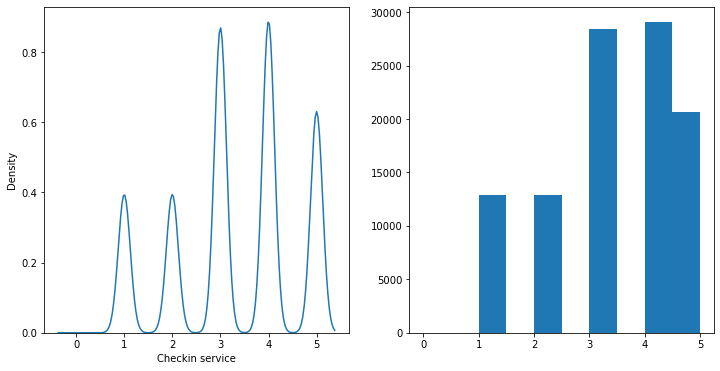

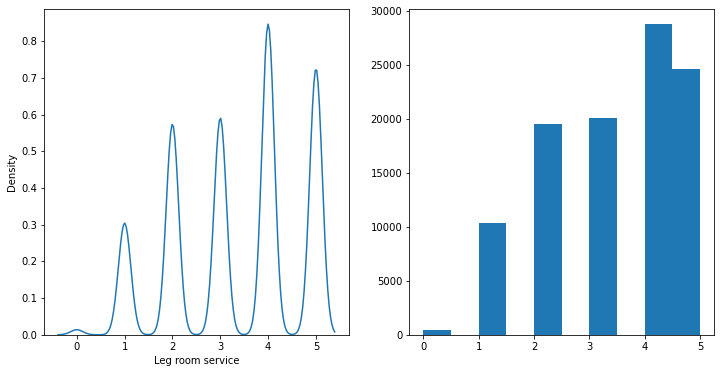

C:\Users\aleksey\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\aleksey\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


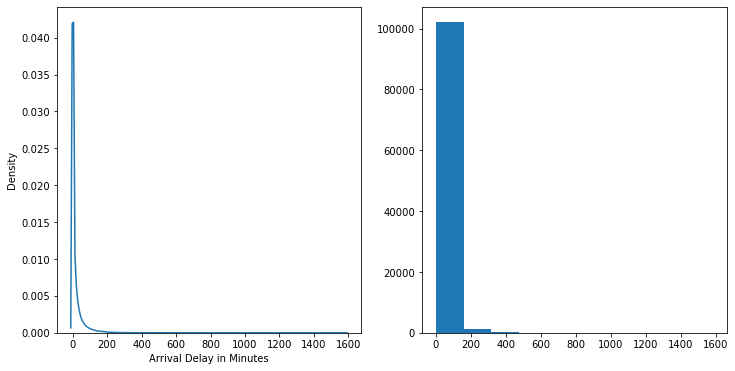

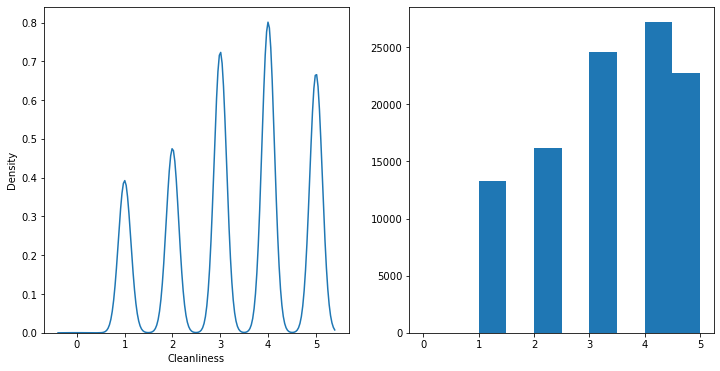

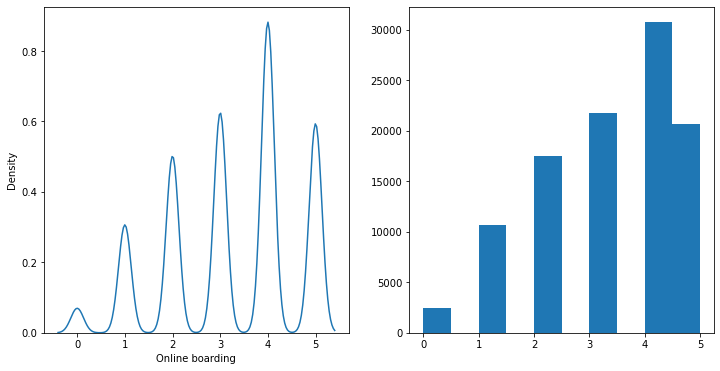

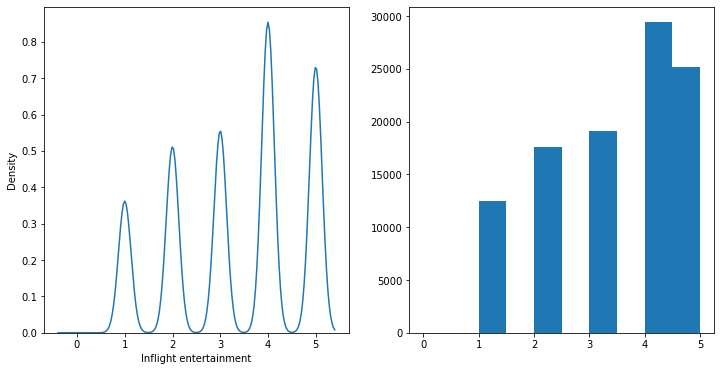

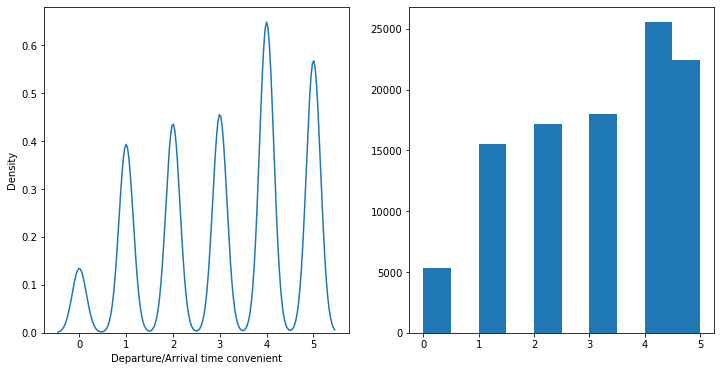

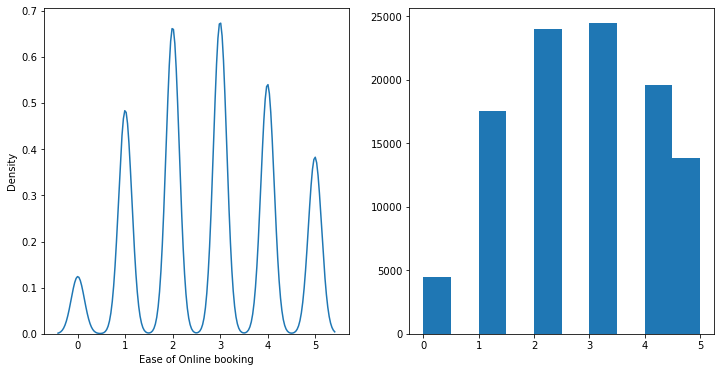

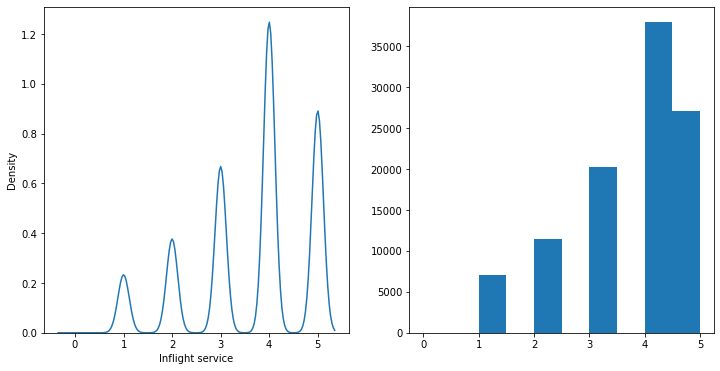

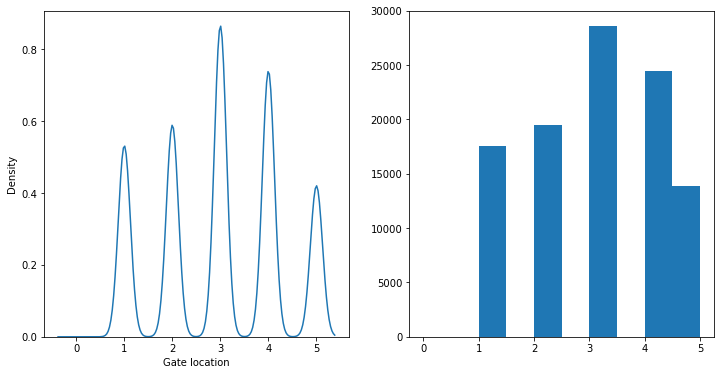

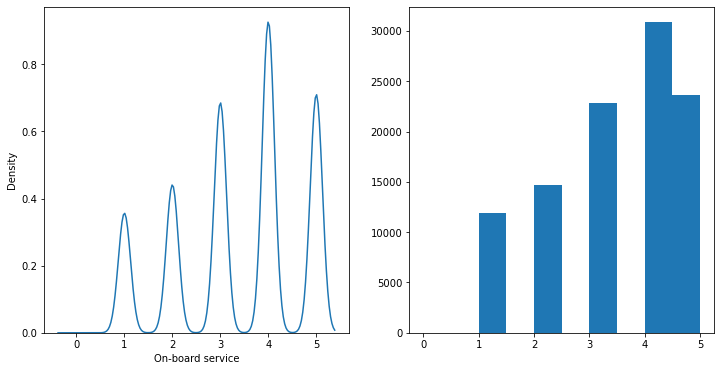

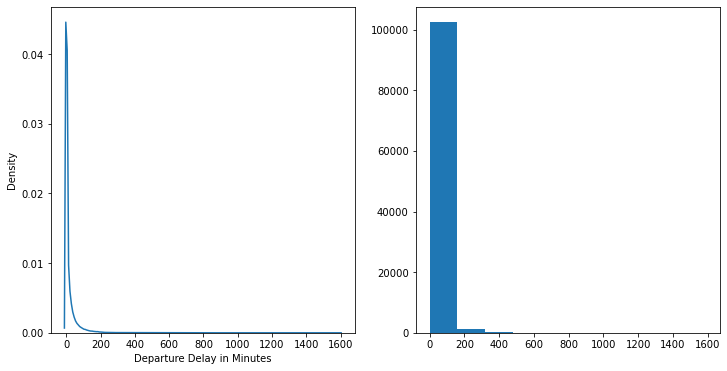

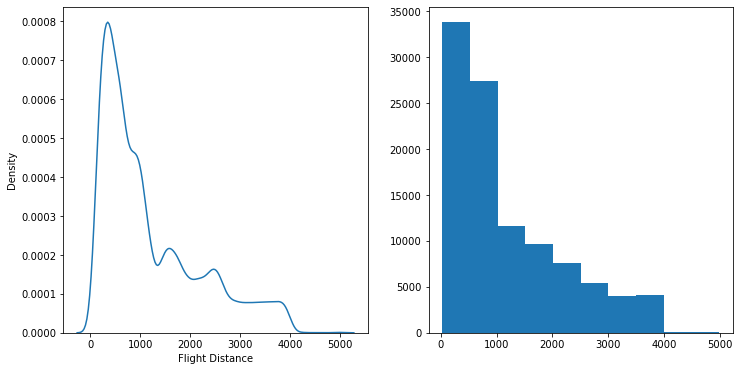

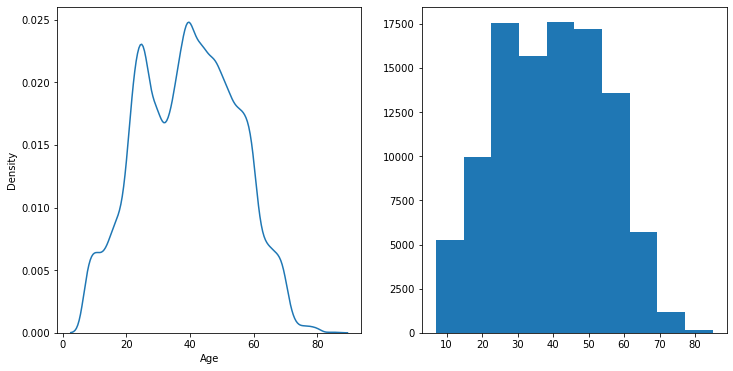

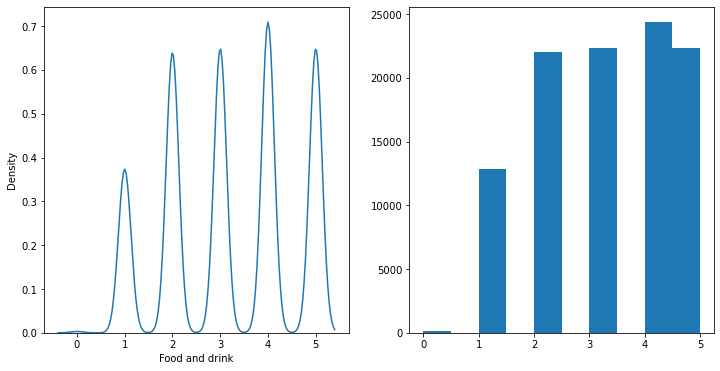

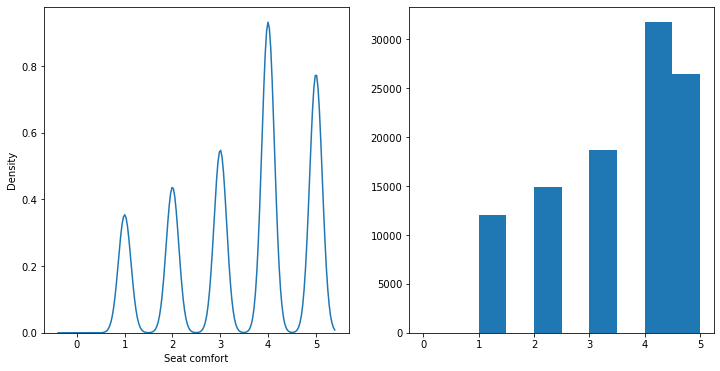

In [84]:
for name in set(df.columns) - set(categorical_columns) - set(['id', 'Unnamed: 0']):
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    sns.kdeplot(df[name])
    plt.subplot(1,2,2)
    plt.hist(df[name])
    plt.show()

В графиках, ничего странного не вужу. У нас, кстати, не было ничего про то каким должно быть распределение для какого алгоритма. 

сделаем разбиение на train и test, train возбмеме 0.3 так как у нас 100к примеров в данных и 30+ колонок. Мы умрем делать кроссвалидацию.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], random_state=123, train_size=0.3)

Собираем наш пайплайн:
- pipe1 - категориальные колонки с на которые мы применяем OrdinalEncoder
- pipe2 - выбираем категории коотыре уже в натуральных числах
- pipe3 - выбираем вещественные признаки
- pipe4 - делаем суммарную колонку для признкаков качесвта сервиса (0-5)

все колонки защищены SimpleImputer от пустых значений, вещественный вставляет медиану, категориальные самые частые, FeatureSum защищен внутри игнорированием nan значений.

In [86]:
pipe1 = Pipeline([
    ('column_selector', FeatureSelector(column=categorical_columns)),
    ('cat_nan_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
])

pipe2 = Pipeline([
    ('column_selector', FeatureSelector(column=categorical_columns2)),
    ('cat_nan_imputer', SimpleImputer(strategy='most_frequent')),
])

pipe3 = Pipeline([
    ('column_selector', FeatureSelector(column=numerical_columns)),
    ('num_nan_imputer', SimpleImputer(strategy='median')) 
])
pipe4 = Pipeline([
    ('sum_of_cat', FeatureSum(column=categorical_columns2))
])

feats_test = FeatureUnion(
    [('categorical', pipe1),
    ('categorical2', pipe2),
    ('numbers', pipe3),
    ('cat2_sum', pipe4)]
)


сделаем параметры для кросвалидации

In [87]:
n_estimators = np.linspace(25, 500, 15, dtype='int32')
learning_rate = np.linspace(0.01, 2, 15)
max_depth = [i+1 for i in range(7)]

In [88]:
pg = [{
    'gboost': [GradientBoostingClassifier()],
    'gboost__n_estimators': n_estimators,
    'gboost__learning_rate': learning_rate,
    'gboost__max_depth' : max_depth
    }
]

воспользуемся RandomizedSearchCV

In [89]:
rscv = RandomizedSearchCV(gboost_test, scoring='roc_auc', param_distributions=pg, verbose=True, n_jobs=4, cv=3, n_iter=300)

In [90]:
rscv.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 16.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 40.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 87.9min
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed: 99.7min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('feats_test',
                                              FeatureUnion(transformer_list=[('categorical',
                                                                              Pipeline(steps=[('column_selector',
                                                                                               FeatureSelector(column=['Type '
                                                                                                                       'of '
                                                                                                                       'Travel',
                                                                                                                       'Gender',
                                                                                                                       'Class',
                                                                      

In [91]:
rscv.best_estimator_

Pipeline(steps=[('feats_test',
                 FeatureUnion(transformer_list=[('categorical',
                                                 Pipeline(steps=[('column_selector',
                                                                  FeatureSelector(column=['Type '
                                                                                          'of '
                                                                                          'Travel',
                                                                                          'Gender',
                                                                                          'Class',
                                                                                          'Customer '
                                                                                          'Type'])),
                                                                 ('cat_nan_imputer',
                                       

In [92]:
rscv.best_score_

0.9936296656730699

In [93]:
results = pd.DataFrame(rscv.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gboost__n_estimators,param_gboost__max_depth,param_gboost__learning_rate,param_gboost,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,15.981701,0.037519,0.138632,0.002155,92,6,1.14714,GradientBoostingClassifier(learning_rate=0.152...,"{'gboost__n_estimators': 92, 'gboost__max_dept...",0.978098,0.966601,0.959889,0.968196,0.007519,233
1,28.305265,1.965044,0.124637,0.017592,194,5,0.152143,GradientBoostingClassifier(learning_rate=0.152...,"{'gboost__n_estimators': 194, 'gboost__max_dep...",0.992810,0.993546,0.993802,0.993386,0.000421,8
2,22.334048,3.193288,0.131635,0.024078,194,5,1.85786,GradientBoostingClassifier(learning_rate=0.152...,"{'gboost__n_estimators': 194, 'gboost__max_dep...",0.801057,0.840490,0.875348,0.838965,0.030348,263
3,16.918083,0.230651,0.107505,0.004326,330,2,0.294286,GradientBoostingClassifier(learning_rate=0.152...,"{'gboost__n_estimators': 330, 'gboost__max_dep...",0.989571,0.990337,0.990935,0.990281,0.000558,95
4,8.750670,0.146118,0.080882,0.008091,92,4,1.005,GradientBoostingClassifier(learning_rate=0.152...,"{'gboost__n_estimators': 92, 'gboost__max_dept...",0.987196,0.989770,0.988146,0.988371,0.001063,124


In [94]:
results.sort_values('mean_test_score', ascending=False)[['params', 'mean_test_score', 'std_test_score']].head()

,params,mean_test_score,std_test_score
183,"{'gboost__n_estimators': 466, 'gboost__max_dep...",0.993630,0.000299
246,"{'gboost__n_estimators': 296, 'gboost__max_dep...",0.993614,0.000309
30,"{'gboost__n_estimators': 92, 'gboost__max_dept...",0.993552,0.000371
64,"{'gboost__n_estimators': 330, 'gboost__max_dep...",0.993474,0.000485
179,"{'gboost__n_estimators': 296, 'gboost__max_dep...",0.993436,0.000361


In [102]:
results.iloc[183]['params']

{'gboost__n_estimators': 466,
 'gboost__max_depth': 7,
 'gboost__learning_rate': 0.15214285714285716,
 'gboost': GradientBoostingClassifier(learning_rate=0.15214285714285716, max_depth=7,
                            n_estimators=466)}

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], random_state=123, train_size=0.75)

In [107]:
gboost_test = Pipeline([
    ('feats_test', feats_test),
    ('gboost', GradientBoostingClassifier(n_estimators=466, learning_rate=0.15214285714285716, max_depth=7))]
)

In [108]:
gboost_test.fit(X_train, y_train)

Pipeline(steps=[('feats_test',
                 FeatureUnion(transformer_list=[('categorical',
                                                 Pipeline(steps=[('column_selector',
                                                                  FeatureSelector(column=['Type '
                                                                                          'of '
                                                                                          'Travel',
                                                                                          'Gender',
                                                                                          'Class',
                                                                                          'Customer '
                                                                                          'Type'])),
                                                                 ('cat_nan_imputer',
                                       

In [109]:
y_pred = gboost_test.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.9949419418656336